In [1]:
import torch
import os
import numpy as np
import const
import data.prepare_data as pdd
import test as test
import vis_utils as vu
import paper_figures as pf
from scipy.special import softmax
import matplotlib.pyplot as plt

sh: nvidia-smi: command not found


GPU doesn't exist
cpu


In [2]:
dir2read_exp = "../exp_data/exp_group/"  # USER DEFINE
dir2read_data = "../data_group/"  # USER DEFINE

In [3]:
dataset = ["Mineral (r)", "Mineral (p)", "Organic (r)", "Organic (p)", "Bacteria"]
data_g = ["raw", "excellent_unoriented", "organic_target_raw", "organic_target", "bacteria_reference_finetune"]
index = 2  # USER DEFINE
raman_type = data_g[index]
print("---------------------------------------------------------------")
print("           %s spectra matching experiment " % dataset[index])
print("---------------------------------------------------------------")

---------------------------------------------------------------
           Organic (r) spectra matching experiment 
---------------------------------------------------------------


In [4]:
import imp
imp.reload(test)

GPU doesn't exist
cpu


sh: nvidia-smi: command not found


<module 'test' from '/Users/blia/Documents/experiments/contrastive_spectra_matching_public/test.py'>

In [5]:
dir2read_exp = "../exp_data/"
dir2read_data = "../data_group/"

In [6]:
# Load data 
model_dir = dir2read_exp + raman_type + "/" 
model_dir = [model_dir + v for v in os.listdir(model_dir) if "version_" in v][0]
dir2load_data = model_dir + "/data_splitting/"
ckpt_dir = [model_dir + "/" + v for v in sorted(os.listdir(model_dir)) if "repeat_" in v]

args = const.give_args_test(raman_type=raman_type)
args["pre_define_tt_filenames"] = True
if "bacteria" in raman_type:
    tr_data, val_data, tt_data, _, label_name = test.get_data(args, dir2load_data, "cls", False, dir2read_data)
else:
    tr_data, tt_data, _, label_name = test.get_data(args, dir2load_data, "cls", False, dir2read_data)
    val_data = []

In [7]:
# Get prediction on the test dataset
imp.reload(test)
string_use = ["ensemble_%d" % i for i in range(len(ckpt_dir))]
prediction_g = {}
for i, s_ckpt in enumerate(ckpt_dir):
    prediction, _ = test.get_model_baseon_modeldir(args, s_ckpt, 
                                                   [tr_data, tt_data, label_name],
                                                   print_info=True)
    prediction_g[string_use[i]] = prediction
group_index = [np.where(tr_data[1] == i)[0] for i in np.unique(tt_data[1])]
prediction_g, string_use = test.add_ensemble(prediction_g, string_use, False, group_index, tr_data[1], tt_data[1])

sh: nvidia-smi: command not found


GPU doesn't exist
cpu
load weight from ../exp_data/organic_target_raw/version_0_lr_0.00005_Xception_distance_aggregate_wave_channel_dot_L1_lrschedule_cosine_l2regu_0.0010_stem_kernel_21_ch_64_channel_depth_128_dropout_True_drop_within_model_balance_pos_neg_0.500_real_separable_conv/repeat_0/model-0020.pt
Top 1 Accuracy 100.00 
Top 2 Accuracy 100.00 
Top 3 Accuracy 100.00 
Top 4 Accuracy 100.00 
Top 5 Accuracy 100.00 
load weight from ../exp_data/organic_target_raw/version_0_lr_0.00005_Xception_distance_aggregate_wave_channel_dot_L1_lrschedule_cosine_l2regu_0.0010_stem_kernel_21_ch_64_channel_depth_128_dropout_True_drop_within_model_balance_pos_neg_0.500_real_separable_conv/repeat_1/model-0020.pt
Top 1 Accuracy 97.22 
Top 2 Accuracy 100.00 
Top 3 Accuracy 100.00 
Top 4 Accuracy 100.00 
Top 5 Accuracy 100.00 
load weight from ../exp_data/organic_target_raw/version_0_lr_0.00005_Xception_distance_aggregate_wave_channel_dot_L1_lrschedule_cosine_l2regu_0.0010_stem_kernel_21_ch_64_channel_dep

In [8]:
prediction_ensemble = prediction_g["ensemble_avg"]
prediction_baseon_tr, corr_tr_index = test.reorganize_similarity_score(prediction_ensemble, tr_data[1])
wavenumber = pdd.give_wavenumber(args, dir2read_data)
print("---------------------------------------------------------")
top1_matching_accu = np.sum(np.argmax(prediction_baseon_tr, axis=-1) == tt_data[1]) / len(tt_data[1])
print("Top-1 matching accuracy: %.2f" % (top1_matching_accu * 100))
print("---------------------------------------------------------")


---------------------------------------------------------
Top-1 matching accuracy: 98.61
---------------------------------------------------------


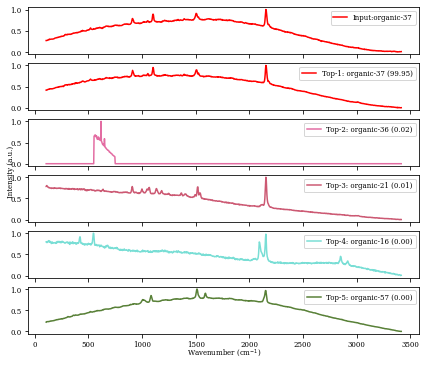

In [9]:
# Show the Top-5 predictions
select_index=np.random.choice(len(prediction_baseon_tr), 1)[0]
vu.show_top5_prediction(select_index, prediction_baseon_tr, corr_tr_index, [tr_data, tt_data, label_name], wavenumber)

### Conformal prediction
1. Get the predictions for the validation spectra 
2. Get a set of sorted predicted score where the smallest score correspond to the score of correctly matching a spectrum
3. Get the threshold based on a user-defined conservative degree 
4. Apply this threshold on the test dataset to produce a set of prediction for each test spectrum

In [10]:
# Conformal prediction example
val_prediction_baseon_cls, val_label = test.get_conformal_prediction_threshold(tr_data, val_data, label_name, 
                                                                               args, ckpt_dir)
val_prediction_score = pf.give_calibration_single_score_prediction(val_prediction_baseon_cls, True,
                                                                   val_label)

In [11]:
alpha_use = 0.00001 # USER DEFINE

In [12]:
threshold = np.quantile(val_prediction_score, alpha_use)
tt_conformal_prediction, \
    tt_conformal_accuracy = pf.give_test_prediction_baseon_single_score_threshold(prediction_baseon_tr,
                                                                     True, tt_data[1],
                                                                     threshold)
tt_correct_or_wrong = [1 if tt_data[1][i] in v else 0 for i, v in enumerate(tt_conformal_prediction)]
print("Top-1 prediction accuracy:        %.2f" % (np.sum(np.argmax(prediction_baseon_tr, axis=-1) == tt_data[1]) / len(tt_data[0]) * 100))
print("Conformal prediction accuracy:    %.2f" % (np.sum(tt_correct_or_wrong) / len(tt_data[0]) * 100))
print("The average predictive set size:   %.2f" % (np.sum([len(v) for v in tt_conformal_prediction]) / len(tt_data[1])))

Top-1 prediction accuracy:        98.61
Conformal prediction accuracy:    98.61
The average predictive set size:   2.58


#### Showing the predictive set for the selected spectrum 

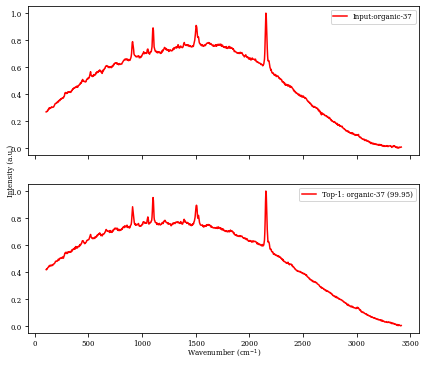

In [13]:
vu.show_top5_prediction(select_index, prediction_baseon_tr, 
                        corr_tr_index, [tr_data, tt_data, label_name], wavenumber, 
                        top5_index=tt_conformal_prediction[select_index])